# Predicting Mars Dust Storm Occurances

Location of the Mars Dust Activity Database (MDAD) - https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/F8R2JX

The goal of this analysis is to predict the area (squared km) of a Martian dust storm at any given time.

Daily mean pressure and temperature of mars - https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OYSRDP

## Data Import

### Notes
- Each row in the database is an individual storm on a specific sol (Mars day). 
- The format of an entry is: Mars Year, Mission subphase, Sol, Ls, Centroid longitude, Centroid latitude, Area (square km), Member ID, Sequence ID, Maximum latitude, Minimum latitude, Confidence interval, Missing data. 
- Each entry has a member ID that can be carried across sols if the motion of the dust storm is feasible. The member ID has the format: SUB_XXX, where “SUB” is the Mission subphase containing the storm, and “XXX” is a number from 001 to 133. 
- Different members can merge into a single member, noted in the member ID with a “+”. The ID of the combining member that is numerically smallest is always listed first in the combined ID. Conversely, a single member can split into multiple members, noted at the end of the member ID with a “b” or “c”. 
- A confidence level of 50,75,100 is subjectively assigned to each dust storm to describe the accuracy of boundaries, with 50 being the least confident. A confidence level of 100 means that the entire perimeter of the dust storm is distinct. 
- Any storm suffering from missing data is labeled with a “yes” under the “missing data” column. Organized dust events with duration of at least 3 sols are called dust storm “sequences” and are identified with a sequence ID with the format: SUB_XX, where “SUB” is the subphase in which the sequence began, and “XX” is a number from 01 to 05. Sequences may merge, indicated with a “+”.

### Import Data

In [1]:
import pandas as pd
storms = pd.read_csv('MDAD.csv')

In [2]:
#take a look at the first records
storms.head()

,Mars Year,Mission subphase,Sol,Ls,Centroid longitude,Centroid latitude,Area (square km),Member ID,Sequence ID,Maximum latitude,Minimum latitude,Confidence interval,Missing data
0,29,B01,1,120.9,28.85,76.95000,90356.984,B01_001,NaN,83.25,71.35,75,no
1,29,B01,2,121.4,29.65,74.25000,156925.090,B01_001,NaN,81.95,66.85,50,no
2,29,B01,2,121.4,-117.05,-7.64999,35037.652,B01_004,NaN,-5.45,-9.95,100,no
3,29,B01,3,121.8,36.05,71.75000,209257.090,B01_001,NaN,77.45,64.75,50,no
4,29,B01,3,121.8,-146.55,77.65000,186898.530,B01_006,NaN,84.25,70.05,50,no


## Data Visualization

Here we will check for quality issues with the data

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#set ticks to white so I can see with my black background
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
#plt.rcParams.update(params)

In [4]:
storms.columns

Index(['Mars Year', 'Mission subphase', 'Sol', 'Ls', 'Centroid longitude',
       'Centroid latitude', 'Area (square km)', 'Member ID', 'Sequence ID',
       'Maximum latitude', 'Minimum latitude', 'Confidence interval',
       'Missing data'],
      dtype='object')

In [5]:
storms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14974 entries, 0 to 14973
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mars Year            14974 non-null  int64  
 1   Mission subphase     14974 non-null  object 
 2   Sol                  14974 non-null  int64  
 3   Ls                   14974 non-null  float64
 4   Centroid longitude   14974 non-null  float64
 5   Centroid latitude    14974 non-null  float64
 6   Area (square km)     14974 non-null  float64
 7   Member ID            14974 non-null  object 
 8   Sequence ID          5102 non-null   object 
 9   Maximum latitude     14974 non-null  float64
 10  Minimum latitude     14974 non-null  float64
 11  Confidence interval  14974 non-null  int64  
 12  Missing data         14974 non-null  object 
dtypes: float64(6), int64(3), object(4)
memory usage: 1.5+ MB


### Missing Data Count

Text(0, 0.5, 'Number of Storms')

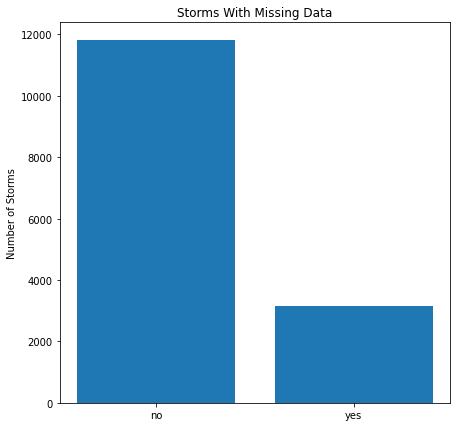

In [6]:
#missing data count
plt.figure(figsize=(7,7))
plt.bar(storms['Missing data'].value_counts().index,storms['Missing data'].value_counts().values)
plt.title("Storms With Missing Data")
plt.ylabel("Number of Storms")

In [7]:
total_entries = len(storms['Missing data'])

(storms['Missing data'].value_counts()/total_entries).round(3)*100

no     78.8
yes    21.2
Name: Missing data, dtype: float64

This is an interesting developement. It will be worth checking to see if impact of predicts are affected by including the storms that have missing data vs the storms that do not. Even though the data is classified as "missing", the provided data does not actually contain missing data.

In [8]:
storms['Missing data'] = pd.get_dummies(storms['Missing data'])['no']

### Average Length of Missions

In [9]:
total_missions = len(storms['Mission subphase'].value_counts().index)
print("Total Number of Missions:", total_missions)

Total Number of Missions: 179


In [12]:
#storms[['Mission subphase','Sol']]

missions_length = storms.groupby(['Mission subphase']).max()['Sol']
missions_length = missions_length.sort_values()
"""
plt.figure(figsize=(7,15))
plt.title("Length of Missions in Sols")
plt.ylabel("Mission ID")
plt.xlabel("Sols")
plt.barh(missions_length.index, missions_length)
"""

'\nmissions_length = storms.groupby([\'Mission subphase\']).max()[\'Sol\']\nmissions_length = missions_length.sort_values()\nplt.figure(figsize=(7,15))\nplt.title("Length of Missions in Sols")\nplt.ylabel("Mission ID")\nplt.xlabel("Sols")\nplt.barh(missions_length.index, missions_length)\n'

In [13]:
print("Average SubMission Length (Sols):", round(missions_length.mean(), 2))

NameError: name 'missions_length' is not defined

The average length of each mission is 28.97 Sols - so about 1 Mars Month.

### Mars Years

In [12]:
print("Number of Mars Years in Survey:",len(storms['Mars Year'].value_counts().index))

Number of Mars Years in Survey: 9


## Train Test Splits

Since this has an element of time to it, we cannot simply do a random split. We will need to train on older data nad reserve part of the newest data to test against.

In [13]:
train_size = 0.5
val_size = 0.2

test_size = 1 - (train_size + val_size)

total_records = len(storms)

train_size = int(round(train_size * total_records,0))
val_size = int(round(val_size * total_records,0))
test_size = int(round(test_size * total_records,0))


train = storms.iloc[:train_size] 
val = storms.iloc[train_size:train_size+test_size]
test = storms.iloc[-test_size:]

#train.to_csv("train.csv")
#val.to_csv("val.csv")
#test.to_csv("test.csv")


In [14]:
print("Training Size:", len(train))
print("Validation Size:", len(val))
print("Test Size:", len(test))

Training Size: 7487
Validation Size: 4492
Test Size: 4492


## Additional Visualization
Now that we have an idea of the quality of the data and high level visualizations of the data, we will now dive deeper into the visualizations.

In [15]:
train.describe()

,Mars Year,Sol,Ls,Centroid longitude,Centroid latitude,Area (square km),Maximum latitude,Minimum latitude,Confidence interval,Missing data
count,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7.487000e+03,7487.000000,7487.000000,7487.000000,7487.000000
mean,30.435956,16.152264,163.354054,-8.899005,-6.895492,9.080070e+05,1.071237,-14.730633,68.278349,0.802725
std,1.037955,9.148801,96.973304,95.743530,49.328366,1.681386e+06,50.798622,47.868271,14.749706,0.397968
min,28.000000,1.000000,0.000000,-179.950000,-82.250000,1.343662e+03,-78.550000,-89.450000,50.000000,0.000000
25%,30.000000,8.000000,76.200000,-78.150000,-49.450000,1.121855e+05,-43.450000,-56.050000,50.000000,1.000000
50%,30.000000,16.000000,162.100000,-28.350000,-27.650000,3.416653e+05,-17.450000,-34.850000,75.000000,1.000000
75%,31.000000,24.000000,226.000000,63.650000,45.350000,9.636997e+05,54.450000,35.150000,75.000000,1.000000
max,32.000000,34.000000,359.600000,179.950000,82.150000,3.005114e+07,89.950000,77.150000,100.000000,1.000000


In [16]:
train.columns

Index(['Mars Year', 'Mission subphase', 'Sol', 'Ls', 'Centroid longitude',
       'Centroid latitude', 'Area (square km)', 'Member ID', 'Sequence ID',
       'Maximum latitude', 'Minimum latitude', 'Confidence interval',
       'Missing data'],
      dtype='object')

Mars Year


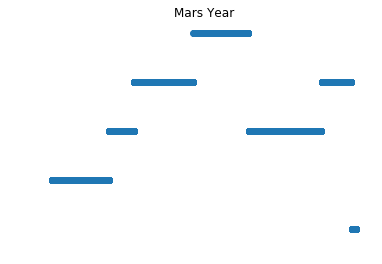

Mission subphase


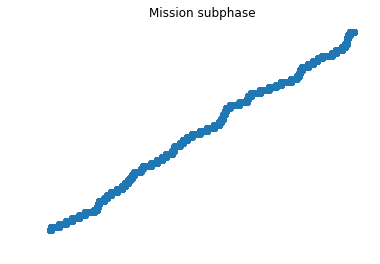

Sol


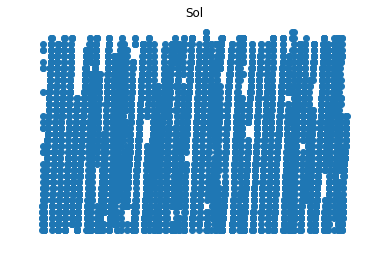

Ls


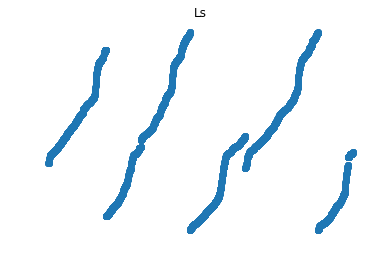

Centroid longitude


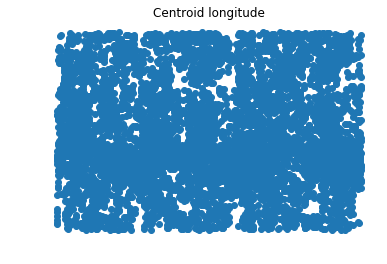

Centroid latitude


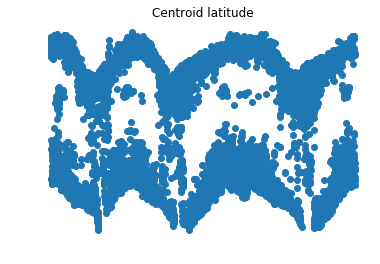

Area (square km)


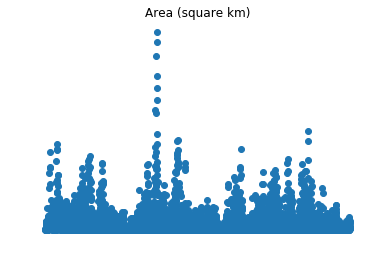

Maximum latitude


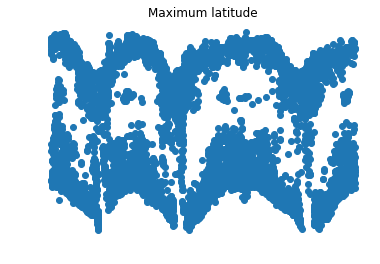

Minimum latitude


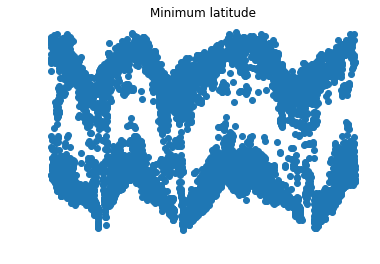

Confidence interval


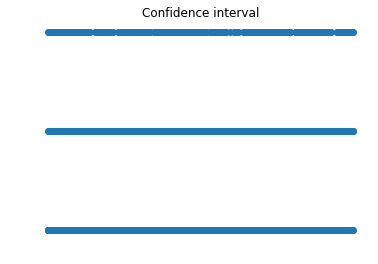

In [17]:
for col in ['Mars Year', 'Mission subphase', 'Sol', 'Ls', 'Centroid longitude',
       'Centroid latitude', 'Area (square km)', 
       'Maximum latitude', 'Minimum latitude', 'Confidence interval']:
    print(col)
    plt.scatter(train.index,train[col])
    plt.title(col)
    plt.show()

Location of Mars Photo: https://en.wikipedia.org/wiki/Geography_of_Mars#/media/File:Mars_Viking_MDIM21_1km_plus_poles.jpg

### Plot logitude and latitudes

In [18]:
from PIL import Image
#image = plt.imread('C:/Users/Taylor Jensen/OneDrive/projects/mars_dust/mars_surface.jpg')
image = Image.open('C:/Users/Taylor Jensen/OneDrive/projects/mars_dust/mars_surface.jpg')

image = image.resize((180,90), Image.ANTIALIAS) #resize to plot over, maximum longitude, latitude

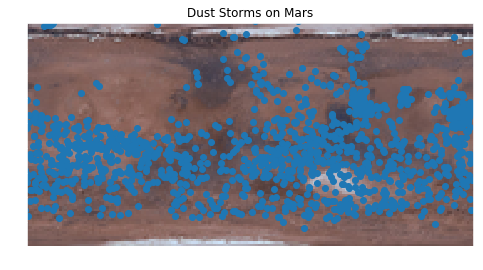

In [19]:
#potential visualization of coordinates of dust storms
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(train['Centroid longitude'], train['Centroid latitude'])
ax.imshow(image, aspect='equal')
plt.title("Dust Storms on Mars");

### Distribution of Sizes

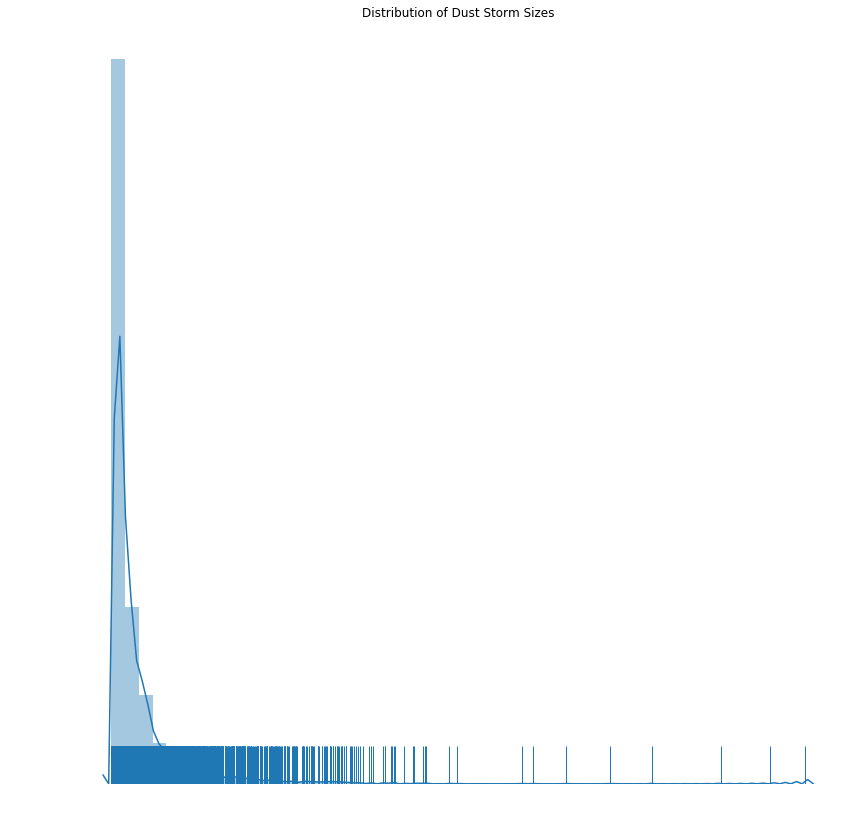

In [20]:
import seaborn as sns
fig = plt.figure(figsize=(14,14))
sns.distplot(train['Area (square km)'], rug=True)
plt.title("Distribution of Dust Storm Sizes")
plt.show()

### Normalized Dataset via Log

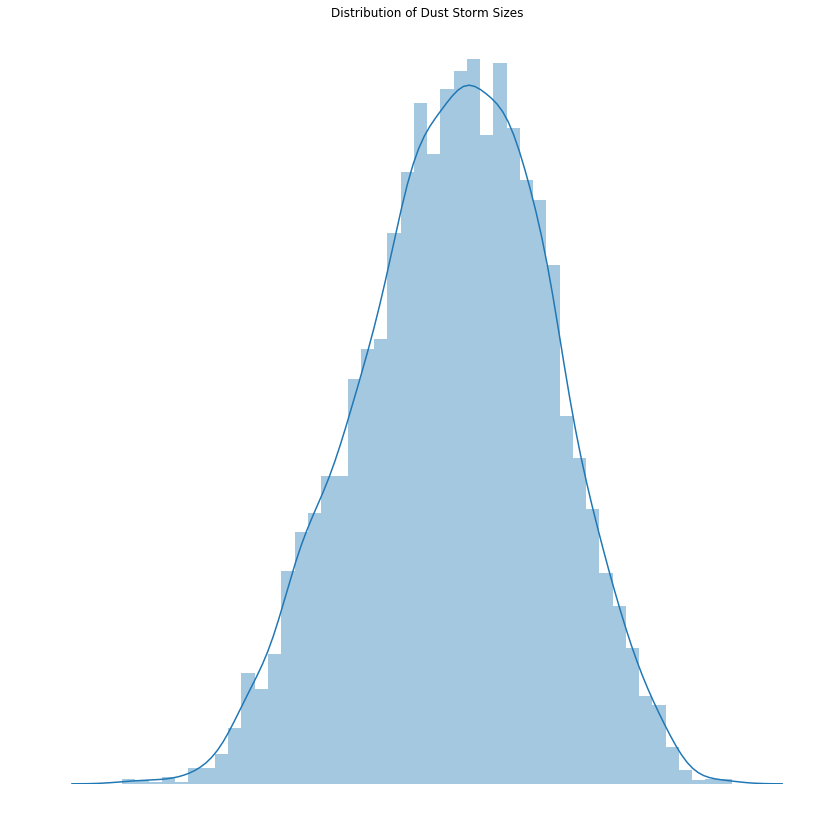

In [21]:
fig = plt.figure(figsize=(14,14))
sns.distplot(np.log(train['Area (square km)']))
plt.title("Distribution of Dust Storm Sizes")
plt.show()

### Data Cleaning
Take Log responses. Put dummy variables for neccesary data

In [22]:
#below are the breakouts of the remaining X and y data
storms.columns

Index(['Mars Year', 'Mission subphase', 'Sol', 'Ls', 'Centroid longitude',
       'Centroid latitude', 'Area (square km)', 'Member ID', 'Sequence ID',
       'Maximum latitude', 'Minimum latitude', 'Confidence interval',
       'Missing data'],
      dtype='object')

In [23]:
#pd.get_dummies(train['Missing data'])['no']
train_y = train['Area (square km)']
train_x = train[['Centroid longitude','Centroid latitude']]#,'Maximum latitude', 'Minimum latitude']]

In [24]:
val_y = val['Area (square km)']
val_x = val[['Centroid longitude','Centroid latitude']]#,'Maximum latitude', 'Minimum latitude']]

# Modeling

## Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [26]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
val_y_pred = lr.predict(val_x)
print("R2 Score: ", lr.score(val_x, val_y))
print("Mean Absolute Error: ", mean_absolute_error(lr.predict(val_x),val_y))

R2 Score:  -0.009817048934540606
Mean Absolute Error:  1211185.4013626438


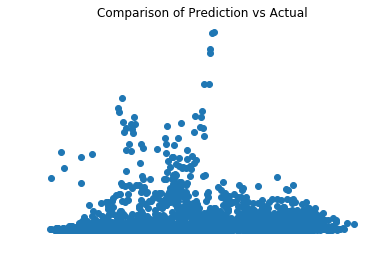

In [28]:
#residual visualization
plt.scatter(val_y_pred, val_y)
plt.title("Comparison of Prediction vs Actual")
#plt.ylim((8,20))
#plt.xlim((8,20))
plt.xlabel("prediction")
plt.ylabel("actual")
plt.show()

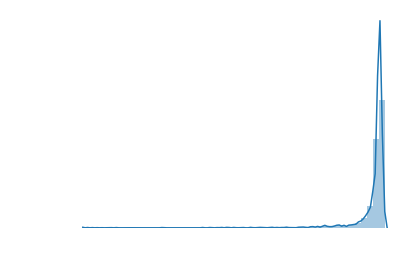

In [29]:
residuals = val_y_pred - val_y
sns.distplot(residuals)

## Decision Tree